<a href="https://colab.research.google.com/github/ucfilho/Machine_Learning_Study/blob/master/BootCamp_Raiana_others/Anomaly_Detection_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCA-based anomaly detection

Anomaly detection is an application of unsupervised learning that detects anomalous samples in datasets and data streams. Airbus uses it to [predict failures in jet engines](https://customers.microsoft.com/en-us/story/858578-airbus-defense-and-intelligence-azure) and [detect anomalies in telemetry data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html) beamed down from the International Space Station. Credit-card companies use it to detect fraudulent transactions. One of the more popular ways to build anomaly-detection models relies on [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis), or PCA. PCA-based anomaly-detection models work by using PCA to transform a dataset, inverting the transform to attempt to restore the original dataset, and measuring the differences between the samples in the original dataset and the restored dataset. Anomalous samples are likely to exhibit a higher difference (loss) than "normal" samples, which enables future samples to be identified as normal or anomalous by computing the loss and comparing it to a chosen loss threshold.

![](Images/airplane.jpg)

This notebook applies PCA-based anomaly detection to a subset of a [dataset published by NASA ](https://www.kaggle.com/vinayak123tyagi/bearing-dataset) to predict failures in bearings. The dataset contains vibration data for four bearings supporting a rotating shaft with a radial load of 6,000 pounds applied to it. The bearings were run to failure, and vibration data was captured by PCB 353B33 high-sensitivity quartz accelerometers at regular intervals until failure occurred. This is analogous to the types of models aircraft manufacturers use to perform predictive maintenance on aircraft and aircraft engines. And it's a great example of how machine learning is used in industry to save lives and solve business problems.

## Load and visualize the data

The first step is to load the dataset, and then plot the data captured by the vibration sensors to get a picture of what happened during the test.

In [ ]:
# https://github.com/jeffprosise/Machine-Learning/blob/master/Anomaly%20Detection%20(PCA).ipynb

In [2]:
!git clone https://github.com/ucfilho/Machine_Learning_DataSet
%cd Machine_Learning_DataSet

Cloning into 'Machine_Learning_DataSet'...
remote: Enumerating objects: 243, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 243 (delta 16), reused 0 (delta 0), pack-reused 195
Receiving objects: 100% (243/243), 72.68 MiB | 26.85 MiB/s, done.
Resolving deltas: 100% (80/80), done.
/content/Machine_Learning_DataSet


In [3]:
import pandas as pd

df = pd.read_csv('bearings_nasa.csv', index_col=0, parse_dates=[0])
df.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


The dataset contains 984 samples. Each sample contains vibration data for four bearings, and the samples were taken 10 minutes apart. Plot the vibration data for all four bearings as a time series.

<Axes: >

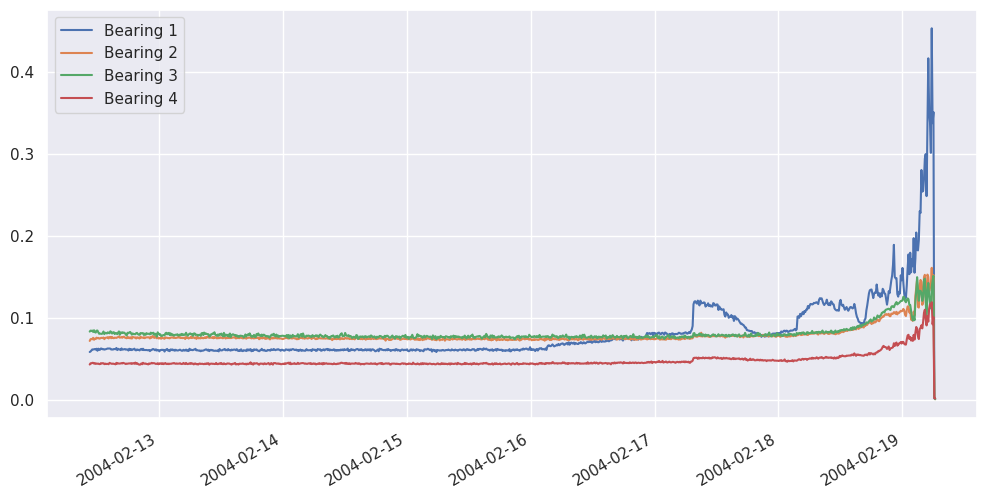

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

df.plot(figsize = (12, 6))

About four days into the test, vibrations in bearing #1 began increasing. They spiked a day later, and about two days after that, bearing #1 suffered a catastrophic failure. Our goal is to build a model that recognizes increased vibration as a sign of impending failure, and PCA is the perfect tool for the job.

## Use PCA to transform and restore the data

The next step is to extract samples representing "normal" operation from the dataset, and reduce four dimensions to one using PCA. Then apply the same PCA transform to the remainder of the dataset, invert the transform, and plot the "restored" dataset to visualize the loss incurred when a PCA transform is applied and inverted. Start by reducing the dataset to one dimension with PCA and plotting the result.

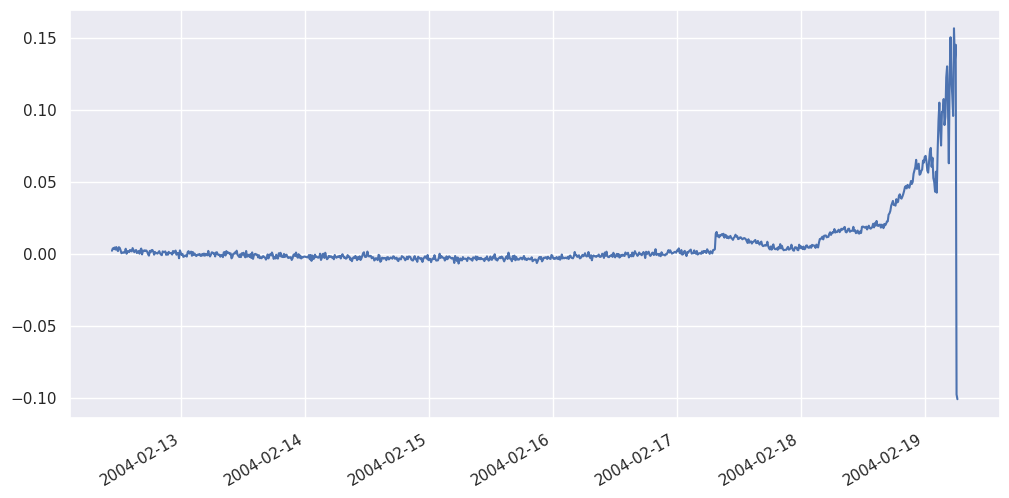

In [5]:
from sklearn.decomposition import PCA

x_train = df['2004-02-12 10:32:39':'2004-02-13 23:42:39']
x_test = df['2004-02-13 23:52:39':]

pca = PCA(n_components=1, random_state=0)
x_train_pca = pd.DataFrame(pca.fit_transform(x_train))
x_train_pca.index = x_train.index

x_test_pca = pd.DataFrame(pca.transform(x_test))
x_test_pca.index = x_test.index

df_pca = pd.concat([x_train_pca, x_test_pca])
df_pca.plot(figsize = (12, 6))
plt.legend().remove()

Now invert the PCA transform and plot the "restored" dataset.

<Axes: >

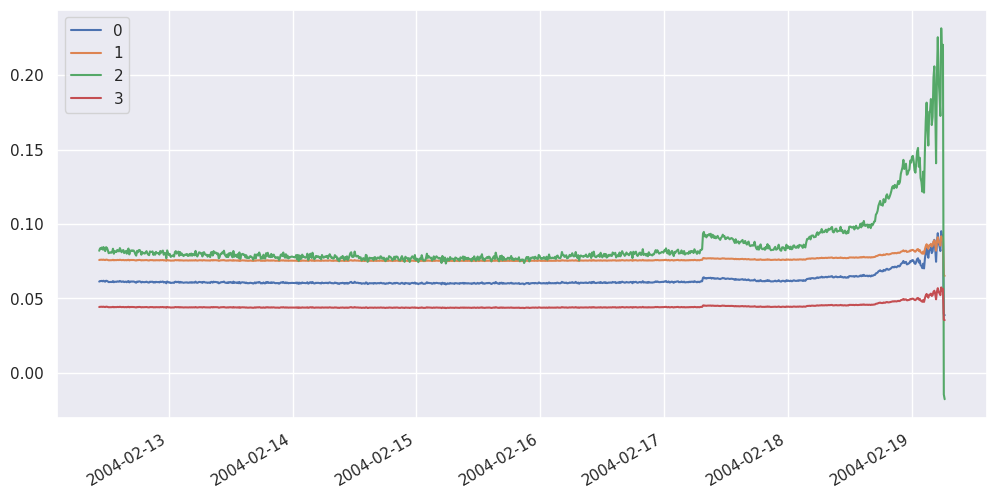

In [6]:
df_restored = pd.DataFrame(pca.inverse_transform(df_pca), index=df_pca.index)
df_restored.plot(figsize = (12, 6))

Examine the original datatset and the restored dataset in numerical form and compare the two.

In [7]:
df.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [8]:
df_restored.head()

,0,1,2,3
2004-02-12 10:32:39,0.061336,0.075812,0.082033,0.044257
2004-02-12 10:42:39,0.061697,0.075981,0.083626,0.044397
2004-02-12 10:52:39,0.061652,0.075960,0.083426,0.044380
2004-02-12 11:02:39,0.061826,0.076042,0.084195,0.044447
2004-02-12 11:12:39,0.061519,0.075898,0.082840,0.044328


It is obvious that loss was incurred by applying and inverting the transform. The magnitude of the loss is roughly the same in all four columns, but that's not surprising given that the first five lines of each dataset represent normal operation. Let's define a function that computes the loss in a range of samples.

In [9]:
import numpy as np

def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss

Now apply that function to all of the samples in the original dataset and the restored dataset and plot the differences over time.

<Axes: >

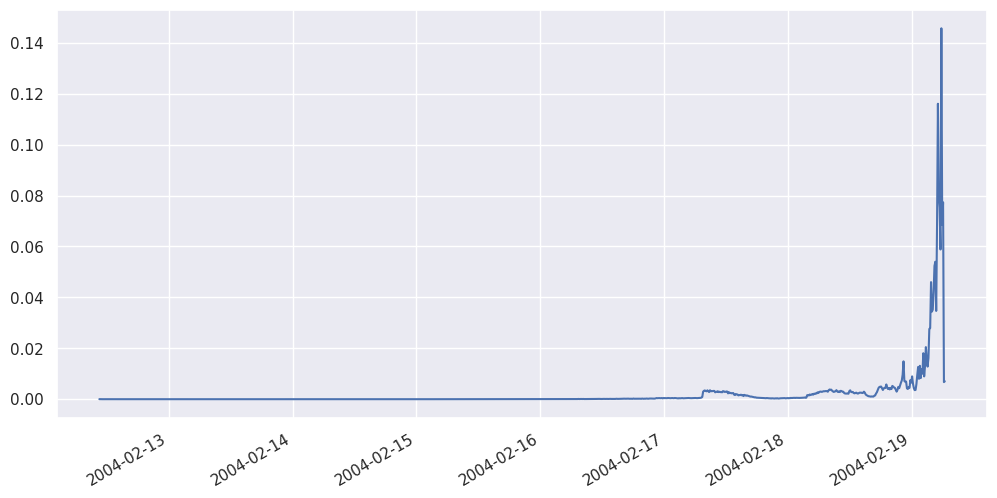

In [10]:
scores = get_anomaly_scores(df, df_restored)
scores.plot(figsize = (12, 6))

It is apparent from this plot that the loss is very small when all four bearings are operating normally, but that the loss begins to rise when one or more bearings exhibits greater-than-normal vibration. It is also apparent that when the loss rises above a threshold value of approximately 0.002, that's an indication that a bearing might fail.

## Use PCA to detect anomalous behavior

Now that we've selected a tentative loss threshold, we can use it to detect anomalous behavior in the bearing set. Begin by defining a function that takes a sample as input and returns `True` or `False` indicating whether the sample is anomalous by applying and inverting a PCA transform, measuring the loss, and comparing it to a specified loss threshold.

In [11]:
def is_anomaly(data, pca, threshold):
    pca_data = pca.transform(data)
    restored_data = pca.inverse_transform(pca_data)
    loss = np.sum((data - restored_data) ** 2)
    return loss > threshold

Apply the function to a row early in the time series that represents normal behavior.

In [12]:
x = [df.loc['2004-02-16 22:52:39']]
is_anomaly(x, pca, 0.002)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


False

Apply the function to a row later in the time series that represents anomalous behavior.

In [13]:
x = [df.loc['2004-02-18 22:52:39']]
is_anomaly(x, pca, 0.002)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


True

Apply the function to all the samples in the dataset and shade anomalous samples red in order to visualize when anomalous behavior is detected.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr

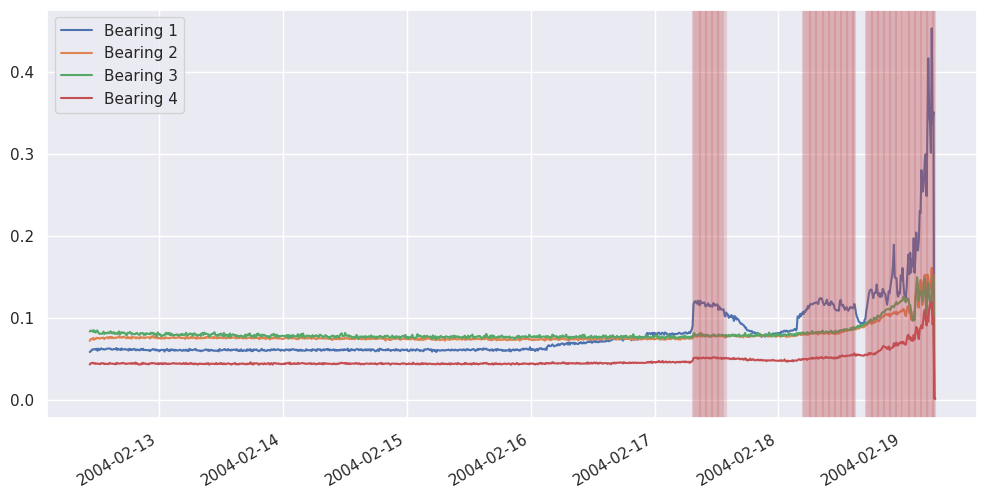

In [14]:
df.plot(figsize = (12, 6))

for index, row in df.iterrows():
    if is_anomaly([row], pca, 0.002):
        plt.axvline(row.name, color='r', alpha=0.2)

Repeat this procedure, but this time use a loss threshold of 0.0002 rather than 0.002 to detect anomalous behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr

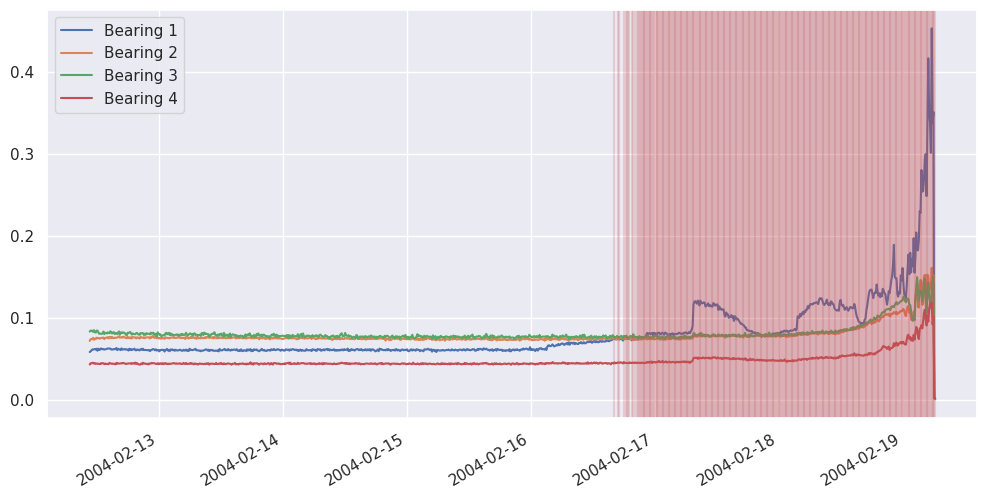

In [15]:
df.plot(figsize = (12, 6))

for index, row in df.iterrows():
    if is_anomaly([row], pca, 0.0002):
        plt.axvline(row.name, color='r', alpha=0.2)

You can adjust the sensitivity of the model by adjusting the threshold value used to identify anomalies. Using a loss threshold of 0.002 predicts bearing failure about two days before it occurs, while a loss threshold of 0.0002 predicts the failure about three days before. You typically want to choose a loss threshold that predicts failure as early as possible without raising false alarms.